In [1]:
from __future__ import print_function
import keras
from keras.models import  Model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from time import time
import time as T
import traceback
import logging
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
#import tensorflow as tf


class Layer(object):
    def __init__(self, units=128, activation='relu', dropout=0):
        self.units = units
        self.posible_activations = ['relu', 'sigmoid', 'tanh', 'elu', 'prelu', 'leakyreLu']
        assert activation in self.posible_activations
        self.activation = activation
        self.dropout = dropout
        self.units_lim = 1024
        self.units_prob = 0.2
        self.act_prob = 0.2
        self.drop_prob = 0.2

    def cross(self, other_layer):
        new_units = self.cross_units(other_layer.units)
        new_activation = self.cross_activation(other_layer.activation)
        new_dropout = self.cross_dropout(other_layer.dropout)
        return Layer(new_units, new_activation, new_dropout)

    def cross_activation(self, other_activation):
        if np.random.rand() > 0.5:
            return self.activation
        return other_activation

    def cross_dropout(self, other_dropout):
        b = np.random.rand()
        return self.dropout * (1 - b) + b * other_dropout

    def cross_units(self, other_units):
        b = np.random.rand()
        return int(self.units * (1 - b) + other_units * b)

    def mutate(self):
        aleatory = np.random.rand(4)
        if aleatory[0] < self.units_prob:
            self.units = np.random.randint(0, self.units_lim)
        if aleatory[1] < self.act_prob:
            self.activation = random.choice(self.posible_activations)
        if aleatory[2] < self.drop_prob:
            self.dropout = np.random.rand()

    def compare(self, other_layer):
        if self.units != other_layer.units:
            return False
        if self.activation != other_layer.activation:
            return False
        if self.dropout != other_layer.dropout:
            return False
        return True

    def self_copy(self):
        return Layer(self.units, self.activation, self.dropout)

    def random_layer(self):
        units = np.random.randint(0, self.units_lim)
        act = random.choice(self.posible_activations)
        drop = np.random.rand()
        return Layer(units, act, drop)

    def __repr__(self):
        return "U:%d|A:%s|D:%0.3f" % (self.units, self.activation, self.dropout)


class Cromosome(object):

    def __init__(self, layers=[], fit=None):
        assert type(layers) == list
        self.n_layers = len(layers)
        self.layers = layers
        self.max_layers = 10
        self.layer_prob = 0.1
        self.fit = None
        self.evaluator = Fitness.get_instance()

    def set_fitness(self, fit):
        self.evaluator = fit

    def random_indiv(self):
        n_layers = np.random.randint(0, self.max_layers)
        layers = [Layer().random_layer() for i in range(n_layers)]
        return Cromosome(layers)

    @staticmethod
    def simple_indiv():
        return Cromosome([Layer()])

    def cross(self, other_cromosome):
        new_layers = []

        if self.n_layers == 0:
            return other_cromosome

        n_intersection = np.random.randint(0, self.n_layers)
        for i in range(self.n_layers):
            if i < n_intersection or i >= other_cromosome.n_layers:
                new_layers.append(self.layers[i].self_copy())
            else:
                try:
                    new_layers.append(self.layers[i].cross(other_cromosome.layers[i - n_intersection]))
                except IndexError:
                    print("Problem with index %d" % i)
                    print("Intersection point at %d" % n_intersection)
                    print(len(self.layers), self.layers)
                    print(len(other_cromosome.layers), other_cromosome.layers)
                    print(len(new_layers), new_layers)
                    raise IndexError
        return Cromosome(new_layers)

    def mutate(self):
        for i in range(self.n_layers):
            self.layers[i].mutate()
        if np.random.rand() < self.layer_prob and self.n_layers < self.max_layers:
            self.layers.append(Layer().random_layer())
            self.n_layers = len(self.layers)

    def equals(self, other_cromosome):
        if self.n_layers != other_cromosome.n_layers:
            return False
        for i in range(self.n_layers):
            if not self.layers[i].compare(other_cromosome.layers[i]):
                return False
        return True

    def __repr__(self):
        rep = ""
        for i in range(self.n_layers):
            rep += "%d - %s \n" % (i, self.layers[i])
        return rep

    def fitness(self):
        return self.evaluator.calc(self)


class Fitness:
    __instance = None

    @staticmethod
    def get_instance():
        """ Static access method. """
        if Fitness.__instance == None:
            Fitness()
        return Fitness.__instance

    def __init__(self):
        """ Virtually private constructor. """
        if Fitness.__instance != None:
            raise Exception("This class is a singleton!")
        else:
            Fitness.__instance = self

    def set_params(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateau=True, verbose=1,
                  reset=True, test=False):
        self.reset = reset
        self.test =test
        self.time = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateau
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.num_clases = self.y_train.shape[1]
        self.callbacks = []
        if self.early_stop and keras.__version__=='2.2.4':
            #self.run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        elif self.early_stop:
            self.callbacks.append(EarlyStopping(monitor='val_acc', patience=10))
        if self.reduce_plateu:
            self.callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, 
                                                    patience=5, verbose=self.verb))
        return self

    def calc(self, chromosome):
        try:
            ti = time()
            if self.reset:
                keras.backend.clear_session()
            model = self.decode(chromosome)
            h = model.fit(self.x_train, self.y_train,
                              batch_size=self.batch_size,
                              epochs=self.epochs,
                              verbose=self.verb,
                              validation_data=(self.x_val, self.y_val),
                              callbacks=self.callbacks)
            score = model.evaluate(self.x_val, self.y_val, verbose=0)
            if self.test:
                score_t = model.evaluate(self.x_test, self.y_test, verbose=0)
        except Exception as e:
            score = [0,0]
            score_t = [0,0]
            print("Some Error with gen:")
            print(chromosome)
            logging.error(traceback.format_exc())
            keras.backend.clear_session()
        if self.verb:
            print('Val loss: %0.4f, Val acc: %0.4f' % (score[0], score[1]))
            if self.test:
                print('Test loss: %0.4f, Test acc: %0.4f' % (score_t[1], score_t[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        self.time += time() - ti
        return score[1]

    def decode(self, chromosome):

        inp = Input(shape=(28, 28, 1))
        x = Flatten()(inp)
        for i in range(chromosome.n_layers):
            act = chromosome.layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
                      #options = self.run_opts)
        return model

    def show_result(self, history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s' % metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()

    def calc_mean(self, chromosome, iters=5):
        f = []
        ti = time()
        for i in range(iters):
            f.append(self.calc(chromosome))
        print("Acc: %0.3f" % np.mean(f), np.std(f), np.max(f))
        print("Time elapsed: %0.3f" % (time() - ti))
        
    def fitness_N_models(self, c1, c2):
        from keras.layers.core import Activation
        def decode_C(chromosome, inp, name=''):
            x = Flatten()(inp)
            for i in range(chromosome.n_layers):
                act = chromosome.layers[i].activation
                if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                    x = Dense(chromosome.layers[i].units, activation=act)(x)
                elif act == 'prelu':
                    x = Dense(chromosome.layers[i].units)(x)
                    x = PReLU()(x)
                else:
                    x = Dense(chromosome.layers[i].units)(x)
                    x = LeakyReLU()(x)
                x = Dropout(chromosome.layers[i].dropout)(x)
            x = Dense(self.num_clases, activation='softmax', name=name)(x)
            return x
        
        inputs = Input(shape=(28, 28, 1))
        model = Model(inputs=inputs, outputs=[decode_C(c1, inputs,'x1'), decode_C(c2, inputs,'x2')],
                        name="all_net")
        losses = {'x1':"categorical_crossentropy", 'x2':"categorical_crossentropy"}
        metrics = {'x1': 'accuracy',
                   'x2': 'accuracy'}
        model.compile(optimizer=Adam(), loss=losses, metrics=metrics)
        model.summary()
        model.fit(self.x_train, [self.y_train, self.y_train],
                  batch_size=self.batch_size,
                  epochs=self.epochs,
                  verbose=self.verb,
                  validation_data=(self.x_val, [self.y_val, self.y_val]))
                  #callbacks=self.callbacks)
        score = model.evaluate(self.x_val, [self.y_val, self.y_val], verbose=1)
        return score
        
        


Using TensorFlow backend.


In [2]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# dataset params:
dataset = 'fashion_mnist'
classes = []

# genetic algorithm params:
parents_selector_key = 'wheel'
num_parents = 0.3
generations = 40
population = 15
train_time = 11

# Fitness params
epochs = 50
maximize_fit = True
reset= True
verbose = 0
redu_plat = False
test = False
early_stop = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, reset=reset, early_stop=early_stop)
p = ps[parents_selector_key]

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


Genetic algorithm params:
Number of generations: 40
Population size: 15
num parents: 4
offspring size: 11
1) best fit: 0.898 in batch time: 800.22
5) best fit: 0.902 in batch time: 2279.81
9) best fit: 0.904 in batch time: 2174.84
13) best fit: 0.904 in batch time: 2060.62
17) best fit: 0.904 in batch time: 1978.39
21) best fit: 0.905 in batch time: 2160.47
25) best fit: 0.905 in batch time: 2300.45
29) best fit: 0.905 in batch time: 2388.93
33) best fit: 0.905 in batch time: 2051.40
37) best fit: 0.905 in batch time: 2131.16
41) best fit: 0.905 in batch time: 1749.59
Making statistical validation
Logging data:
[0.905, 0.9016666666666666, 0.9055833333333333, 0.90725, 0.9049166666666667]
[0.90025    0.89858333 0.8965     0.89991667 0.90325   ]
Benchmark score: 0.8997. Winner score: 0.9049
t = 3.624989312694879
p = 0.006733730326124515
Best Gen ->  0 - U:758|A:sigmoid|D:0.368 
1 - U:740|A:sigmoid|D:0.368 

With Fitness: 0.905


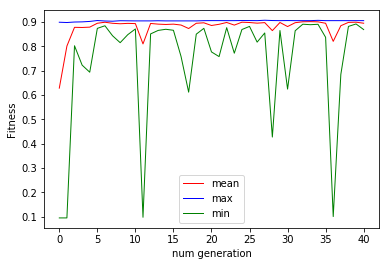

Total elapsed time: 22716.626
Total training time: 22716.433


In [3]:
ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, crossover_prob=0.5, mutation_prob=0.7,
                              maximize_fitness=maximize_fit, training_hours=train_time)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [4]:
fitness.calc_mean(c)
fitness.calc_mean(winner)

Acc: 0.899 0.001594260539142418 0.9014166666666666
Time elapsed: 164.969
Acc: 0.902 0.0023982632605005294 0.9061666666666667
Time elapsed: 231.924


In [ ]:
fitness.fitness_N_models(c, c)
print("Training time: %0.3f" % fitness.time)

In [ ]:
def time_measure(chrom, iters=50):
    
    times = []
    for i in range(iters):
        ti = time()
        c.fitness()
        times.append(time() - ti)
    return times

l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])


# params:
dataset = 'mnist'
classes = [4, 9]
epochs = 2

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs, reset=True)

t_with_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_with_reset), np.std(t_with_reset)))

In [ ]:
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs, reset=False)

t_without_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_without_reset), np.std(t_without_reset)))

In [ ]:
from scipy import stats
t_value, p_value = stats.ttest_ind(t_without_reset, t_with_reset)
print("T-value: %0.3f " % t_value)
print("P-value: %0.3f " % p_value)

In [ ]:
ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# params:
dataset = 'fashion_mnist'
classes = [0, 1, 2]
parents_selector_key = 'wheel'
num_parents = 0.3
generations = 30
population = 10
maximize_fit = True

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False)

p = ps[parents_selector_key]

ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, crossover_prob=0.5, mutation_prob=0.7,
                              maximize_fitness=maximize_fit)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

Chromosome to minimize the fuction:

\begin{equation}
f(x) = x \cdot sin(4x) + 1.1  y \cdot sin(2y)
\end{equation}

In [ ]:



class chrom:
    def __init__(self, x=0, y=0, mutation_prob=0.2):
        self.x = x
        self.y = y
        self.mut_prob = mutation_prob
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit

In [ ]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5

c = chrom(mutation_prob=mut_prob)
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True)

winner, best_fit, ranking = generational.evolve(show=False)
print(best_fit)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    continue
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=50, marker='x')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitness')
ax.set_ylim((np.min(Y), np.max(Y)))
cbar = fig.colorbar(cs)
plt.show()

In [ ]:
h = generational.population_history
def scatter_pop(h, generation, ax):
    for p in h[generation]:
        ax.scatter(p.x, p.y, c='g', label='min', s=100)
        
print(len(h), generations)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((np.min(X), np.max(X)))
ax.set_ylim((np.min(Y), np.max(Y)))
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=100, marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
title = ax.set_title('')
plt.close(fig)
            
def animate2(i):
    ax.cla()
    ax.set_title('generation %s' % str(i).zfill(4))
    cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
    for i_, k_ in min_idxs:
        ax.scatter(x[k_], y[i_], c='k', label='min', s=100, marker='x')
    ax.set_xlim((np.min(X), np.max(X)))
    ax.set_ylim((np.min(Y), np.max(Y)))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    scatter_pop(h, i, ax)
    return

In [ ]:
anim = animation.FuncAnimation(fig,
                               animate2,
                               init_func=None,
                               frames=generations,
                               interval=100000)

# Set up formatting for the movie files
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/anim2.gif', writer=writer)

In [ ]:
HTML(anim.to_html5_video())

animation.FuncAnimation?

In [ ]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5
iters = 1000

c = chrom(mutation_prob=mut_prob)

ps = {'random':RandomParentSelector(), 'linealI':LinealOrder(), 'linealII':LinealOrderII(), 
      'wheel':WheelSelection(), 'tournament5': TournamentSelection(5), 'tournament3': TournamentSelection(3)}

all_fits = {}
for key in ps.keys():
    if key == 'wheel':
        continue
    print("Evaluating " + key + "parent selector")
    p = ps[key]
    all_fits[key] = []
    for i in range(iters):
        generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

        winner, best_fit, ranking = generational.evolve(show=False)
        all_fits[key].append(best_fit)



In [ ]:
for key, value in all_fits.items():
    print(key,"score: %0.4f  +-  %0.4f" % (np.mean(value), np.std(value)))

### Lineal Order I

\begin{equation}
SelectionProb_i = \frac{Position_i}{\sum_{j}{Position_j}}
\end{equation}

### Lineal Order II

\begin{equation}
SelectionProb_i = \frac{N_{keep} - Position_i + 1}{\sum_{j}^{N_{keep}}{Position_j}}
\end{equation}